In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score

In [3]:
TRAIN_PATH = 'drive/MyDrive/СпецПрога/5 Classification/passenger-satisfaction/pass_satisfaction_train.csv'
TEST_PATH = 'drive/MyDrive/СпецПрога/5 Classification/passenger-satisfaction/pass_satisfaction_test.csv'
ANSWER_PATH = 'drive/MyDrive/СпецПрога/5 Classification/passenger-satisfaction/answer.csv'

##Data Ananlysis

In [4]:
data = pd.read_csv(TRAIN_PATH)
data.head(5)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,110028,0,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
1,24026,0,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
2,111157,0,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
3,82113,1,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
4,79485,0,Loyal Customer,41,Business travel,Business,853,1,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied


In [5]:
data.drop(columns=['id'], inplace=True)

In [6]:
data.shape

(83123, 23)

In [7]:
data.dtypes

Gender                                 int64
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [8]:
print(len(data['Customer Type'].unique()))
print(len(data['Type of Travel'].unique()))
print(len(data['Class'].unique()))
print(len(data['satisfaction'].unique()))

2
2
3
2


In [9]:
# "Минуты задержки при прибытии" имеют пропуски
data.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             239
satisfaction                           0
dtype: int64

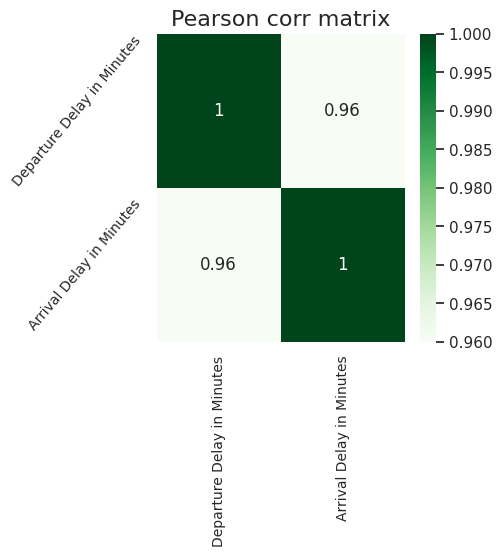

In [10]:
# Видно, что задержка посадки и высадки зависят линейно
sns.set(rc={'figure.figsize':(4, 4)})
sns.heatmap(data[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].corr().round(2), annot=True, cmap="Greens")
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=50)
plt.title("Pearson corr matrix", fontsize=16)
plt.show()

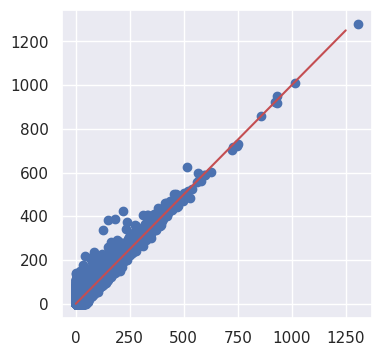

In [11]:
# Прямая пропорциональность
plt.scatter(data['Departure Delay in Minutes'], data['Arrival Delay in Minutes'])
plt.plot([0, 1250], [0, 1250], c='r')

In [12]:
# Заполним пропуски в "Arrival Delay in Minutes" значениями из "Departure Delay in Minutes"
data.loc[data['Arrival Delay in Minutes'].isna(), 'Arrival Delay in Minutes'] =\
    data.loc[data['Arrival Delay in Minutes'].isna(), 'Departure Delay in Minutes']

##Визуализируем нормированные данные

In [13]:
data_clipped = data[(data['Arrival Delay in Minutes'] < 100) & (data['Departure Delay in Minutes'] < 100)]

In [14]:
# data_new = data.copy()

In [15]:
data_scaled = data_clipped.copy()

In [16]:
def scaler(data_train, data_test, name_col):
    m = data_train[name_col].mean()
    std = data_train[name_col].std()
    return (data_test[name_col] - m) / std

columns_cont = ['Age', 'Flight Distance', 
                'Departure Delay in Minutes', 
                'Arrival Delay in Minutes']               
numerical_col = data_scaled.select_dtypes(include=['int64', 'float64']).columns.values

for col in numerical_col:
    data_scaled[col] = scaler(data_clipped, data_scaled, col)

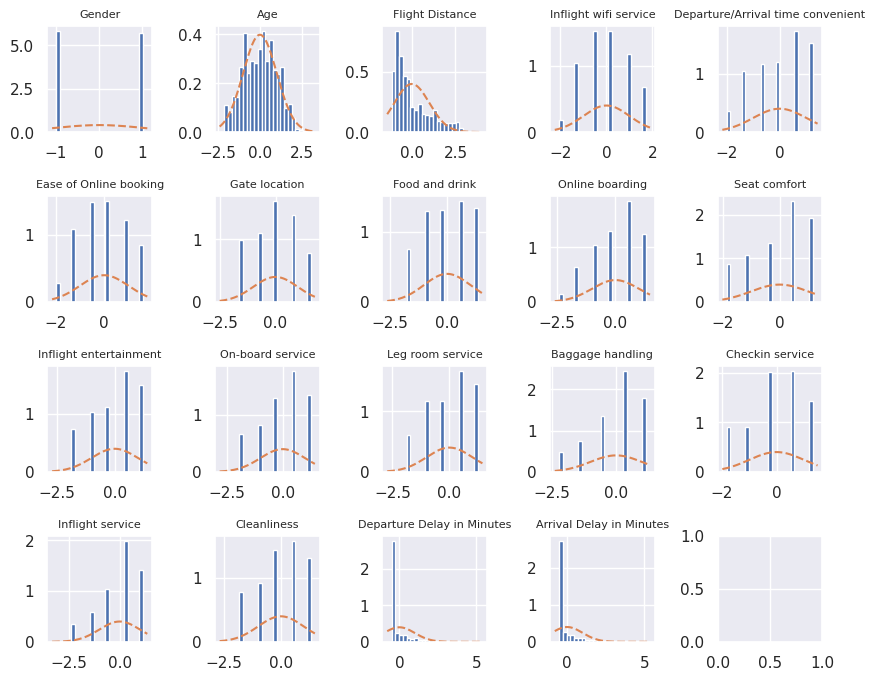

In [17]:
keys = data_scaled.select_dtypes(include=['int64', 'float64']).columns.values
keys = list(keys)

fig, axes = plt.subplots(4, 5)
plt.subplots_adjust(wspace=0.6, hspace=0.6)
fig.set_size_inches(10, 8)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(data_scaled[key], density=True, bins=23)
    
    loc = data_scaled[key].mean()
    scale = data_scaled[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key, fontsize=8)
     

In [18]:
data_scaled.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,-0.987721,Loyal Customer,-0.887040,Business travel,Business,-0.049393,-0.551978,-0.697120,-0.542032,-0.764737,...,1.225014,0.473251,-0.262144,0.309999,0.551012,0.296856,1.304364,-0.507491,-0.519816,satisfied
1,-0.987721,Loyal Customer,-0.953168,Business travel,Business,-0.630054,-0.551978,1.270147,1.602888,1.583104,...,-1.024269,-1.081926,1.254281,-0.535859,-1.824252,0.296856,-0.982786,0.116143,-0.010033,neutral or dissatisfied
2,-0.987721,Loyal Customer,-0.887040,Personal Travel,Eco,-0.011350,0.200374,0.614391,-0.542032,-1.547351,...,-1.774030,-0.304338,0.496068,0.309999,0.551012,0.296856,-1.745170,-0.507491,-0.519816,neutral or dissatisfied
3,1.012419,Loyal Customer,0.501650,Personal Travel,Eco,0.084759,-0.551978,0.614391,-0.542032,0.017877,...,-1.024269,-0.304338,-0.262144,0.309999,-0.240743,1.151567,-0.982786,0.002755,0.782963,neutral or dissatisfied
4,-0.987721,Loyal Customer,0.104881,Business travel,Business,-0.338722,-1.304331,-0.697120,-0.542032,-0.764737,...,-1.774030,-1.859514,-1.020357,-2.227573,0.551012,-2.267276,-0.982786,-0.507491,-0.519816,neutral or dissatisfied


In [19]:
columns_object = data_scaled.select_dtypes(['object']).columns.values
for col in columns_object:
    if (col != 'satisfaction'):
        ohe = pd.get_dummies(data_scaled[col])
        data_scaled = pd.merge(data_scaled, ohe, left_index=True, right_index=True)
        data_scaled.drop(columns=[col], inplace=True)

In [20]:
data_scaled.shape

(79852, 27)

##Train model

In [21]:
X, y = data_scaled.drop(columns=['satisfaction']), data_scaled[['satisfaction']]

In [22]:
model = LogisticRegression(penalty='l2', fit_intercept=True, random_state=0)

In [23]:
scores = cross_val_score(model, X, y, groups=y,
                        cv=5, scoring='f1_micro')

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [24]:
scores.mean()

0.875782735042581

In [25]:
model = LogisticRegression(penalty='l2', fit_intercept=True, random_state=0)
model.fit(X, y)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

##Predict

In [ ]:
test_data = pd.read_csv(TEST_PATH)
test = test_data.copy()

In [ ]:
test.loc[test['Arrival Delay in Minutes'].isna(), 'Arrival Delay in Minutes'] =\
    test.loc[test['Arrival Delay in Minutes'].isna(), 'Departure Delay in Minutes']

In [ ]:
test.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')

In [ ]:
for col in numerical_col:
    test[col] = scaler(data_clipped, test, col)

In [ ]:
columns_object = test.select_dtypes(['object']).columns.values
for col in columns_object:
    if (col != 'satisfaction'):
        ohe = pd.get_dummies(test[col])
        test = pd.merge(test, ohe, left_index=True, right_index=True)
        test.drop(columns=[col], inplace=True)

In [ ]:
columns = X.columns.values
for col in columns:
    if (col not in test.columns.values):
        test[col] = 0
test = test[columns]

In [ ]:
preds = model.predict(test)

In [ ]:
test_data['satisfaction'] = preds
answer = test_data[['id', 'satisfaction']]

In [ ]:
answer

,id,satisfaction
0,40853,neutral or dissatisfied
1,15070,satisfied
2,104309,neutral or dissatisfied
3,36427,neutral or dissatisfied
4,7630,satisfied
...,...,...
20776,16548,satisfied
20777,11384,satisfied
20778,58327,neutral or dissatisfied
20779,113956,satisfied


In [ ]:
answer.to_csv(ANSWER_PATH, index=False)